## JA4

In [1]:
import pandas as pd 
import numpy as np


desktop_malware = pd.read_csv('../Datasets/JA4/Dataset2/desktop-malware.csv', sep=';')
desktop_apps_1 = pd.read_csv('../Datasets/JA4/Dataset2/desktop-apps.csv', sep=';')
desktop_apps_2 = pd.read_csv('../Datasets/JA4/Dataset1/Benign.csv', sep=';')
desktop_apps_3 = pd.read_csv('../Datasets/JA4/Dataset2/mydesktop-apps.csv', sep=';')
print(len(desktop_apps_3))

mobile_malware = pd.read_csv('../Datasets/JA4/Dataset2/mobile-malware.csv', sep=';')
mobile_apps = pd.read_csv('../Datasets/JA4/Dataset2/mobile-apps.csv', sep=';')

drop_families = ["Sodinokibi", "Hawkeye", "Nanocore"]
desktop_malware = desktop_malware[~desktop_malware['AppName'].isin(drop_families)]


desktop_malware['label'] = 'DM'
desktop_apps_1['label'] = 'DA'
desktop_apps_2['label'] = 'DA'  # Asignamos DA si son aplicaciones benignas de escritorio
desktop_apps_3['label'] = 'DA'
mobile_malware['label'] = 'MM'
mobile_apps['label'] = 'MA'

df_combined = pd.concat([
    desktop_malware,
    desktop_apps_1,
    desktop_apps_2,
    desktop_apps_3,
    #mobile_malware,
    #mobile_apps
], ignore_index=True)


df_hashing = df_combined.drop(columns=['SrcIP', 'DstIP', 'SrcPort', 'DstPort', 'OrgName', 'JA3hash', 'JA3Shash', 'Version', 'Issuer', 'Subject'])

3766


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
y_ja4 = label_encoder.fit_transform(df_combined['label'])

hasher = FeatureHasher(n_features=1024, input_type='string')
X_ja4 = hasher.fit_transform(df_combined[['JA4hash', 'JA4Shash']].astype(str).values.tolist())

## MALDIST

In [3]:
balanced_data = pd.read_csv("../Datasets/Maldist_balanced1.csv", sep=",")

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

X_maldist = balanced_data.drop(columns=['label'])
y_maldist = balanced_data['label']

## Balanced Data

In [5]:
print(f"JA4 Train: {X_train_ja4.shape}, MalDIST Train: {X_train_maldist.shape}")
print(f"JA4 Test: {X_test_ja4.shape}, MalDIST Test: {X_test_maldist.shape}")

NameError: name 'X_train_ja4' is not defined

In [5]:
import numpy as np
from scipy.sparse import issparse

# Asegurar que X_maldist sea NumPy array
if hasattr(X_maldist, 'values'):
    X_maldist = X_maldist.values  # Para DataFrames de Pandas

# Obtener mínimo de muestras
min_samples = min(X_ja4.shape[0], X_maldist.shape[0])

# Recortar JA4 (sparse)
X_ja4 = X_ja4[:min_samples, :] if issparse(X_ja4) else X_ja4[:min_samples]

# Recortar MalDIST (NumPy array)
X_maldist = X_maldist[:min_samples, :] if X_maldist.ndim > 1 else X_maldist[:min_samples]

# Recortar etiquetas
y = y_ja4[:min_samples]

# Verificación
print(f"JA4: {X_ja4.shape}, MalDIST: {X_maldist.shape}, Etiquetas: {len(y)}")

JA4: (11815, 1024), MalDIST: (11815, 198), Etiquetas: 11815


In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

# Generar índices comunes
indices = np.arange(len(y))  # Usa len(y) o X_ja4.shape[0]
X_train_idx, X_test_idx, y_train, y_test = train_test_split(
    indices, y, test_size=0.3, stratify=y, random_state=42
)

# Dividir JA4 y MalDIST usando los mismos índices
X_train_ja4 = X_ja4[X_train_idx]
X_test_ja4 = X_ja4[X_test_idx]
X_train_maldist = X_maldist[X_train_idx]
X_test_maldist = X_maldist[X_test_idx]

print(f"Entrenamiento - JA4: {X_train_ja4.shape}, MalDIST: {X_train_maldist.shape}, Etiquetas: {len(y_train)}")
print(f"Prueba - JA4: {X_test_ja4.shape}, MalDIST: {X_test_maldist.shape}, Etiquetas: {len(y_test)}")

Entrenamiento - JA4: (8270, 1024), MalDIST: (8270, 198), Etiquetas: 8270
Prueba - JA4: (3545, 1024), MalDIST: (3545, 198), Etiquetas: 3545


# Model

In [7]:
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import numpy as np

#1 Normalización de Features
scaler = StandardScaler()
X_train_maldist = scaler.fit_transform(X_train_maldist)
X_test_maldist = scaler.transform(X_test_maldist)

#2 Balanceo de Clases
class_weights = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights = dict(enumerate(class_weights))

#3 Arquitectura del Modelo Mejorada
# Modalidad JA4
input_ja4 = Input(shape=(X_train_ja4.shape[1],))
dense_ja4 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(input_ja4)  # Regularización L2
dense_ja4 = Dropout(0.4)(dense_ja4)  # Mayor dropout

# Modalidad MalDIST
input_stats = Input(shape=(X_train_maldist.shape[1],))
dense_stats = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(input_stats)
dense_stats = Dropout(0.4)(dense_stats)

# Fusión
merged = Concatenate()([dense_ja4, dense_stats])
shared = Dense(512, activation='relu')(merged)  # Capa más ancha
shared = Dropout(0.6)(shared)  # Dropout más agresivo

# Salida
output = Dense(len(np.unique(y)), activation='softmax')(shared)  # Ajusta según tus clases

# Compilación con Learning Rate ajustado
model = Model(inputs=[input_ja4, input_stats], outputs=output)
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # LR más bajo
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.save('models/hybrid_model.keras') 

2025-05-11 16:17:06.017185: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-05-11 16:17:06.017212: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-05-11 16:17:09.203231: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-05-11 16:17:09.203279: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-05-11 16:17:09.203310: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: fingopolo-HP-Pavilion-Laptop-14-ce3xxx
2025-05-11 16:17:09.203315: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostn

In [8]:
#4 Entrenamiento con Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    [X_train_ja4.toarray(), X_train_maldist],
    y_train,
    epochs=100,  # Máximo de épocas (puede parar antes por early stopping)
    batch_size=64,
    validation_data=([X_test_ja4.toarray(), X_test_maldist], y_test),
    class_weight=class_weights,  # Balanceo
    callbacks=[early_stop],  # Detención temprana
    verbose=1
)

Epoch 1/100
130/130 [==============================] - 3s 17ms/step - loss: 5.7420 - accuracy: 0.4557 - val_loss: 4.6380 - val_accuracy: 0.4827
Epoch 2/100
130/130 [==============================] - 1s 11ms/step - loss: 3.9431 - accuracy: 0.4932 - val_loss: 3.2585 - val_accuracy: 0.5010
Epoch 3/100
130/130 [==============================] - 1s 10ms/step - loss: 2.8014 - accuracy: 0.4982 - val_loss: 2.3565 - val_accuracy: 0.5094
Epoch 4/100
130/130 [==============================] - 2s 12ms/step - loss: 2.0548 - accuracy: 0.4890 - val_loss: 1.7680 - val_accuracy: 0.4925
Epoch 5/100
130/130 [==============================] - 2s 12ms/step - loss: 1.5751 - accuracy: 0.4787 - val_loss: 1.3865 - val_accuracy: 0.4869
Epoch 6/100
130/130 [==============================] - 2s 12ms/step - loss: 1.2586 - accuracy: 0.4756 - val_loss: 1.1276 - val_accuracy: 0.4829
Epoch 7/100
130/130 [==============================] - 1s 11ms/step - loss: 1.0378 - accuracy: 0.4745 - val_loss: 0.9417 - val_accuracy:

In [11]:
# Obtener predicciones (probabilidades)
y_pred_proba = model.predict([X_test_ja4.toarray(), X_test_maldist])
print(y_pred_proba)

# Convertir a clases (índices)
y_pred = np.argmax(y_pred_proba, axis=1) 
y_pred

[[2.1473452e-02 9.7852659e-01]
 [1.2688200e-03 9.9873120e-01]
 [9.9999988e-01 9.0570573e-08]
 ...
 [6.1200171e-06 9.9999392e-01]
 [1.4776388e-08 1.0000000e+00]
 [9.9458718e-01 5.4128398e-03]]


array([1, 1, 0, ..., 1, 1, 0])

In [12]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

          DA       0.97      0.98      0.97      1652
          DM       0.98      0.97      0.98      1893

    accuracy                           0.97      3545
   macro avg       0.97      0.97      0.97      3545
weighted avg       0.97      0.97      0.97      3545



In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')  # 'macro', 'micro', o 'weighted'
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Imprimir resultados
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9735
Precision: 0.9731
Recall: 0.9737
F1 Score: 0.9734


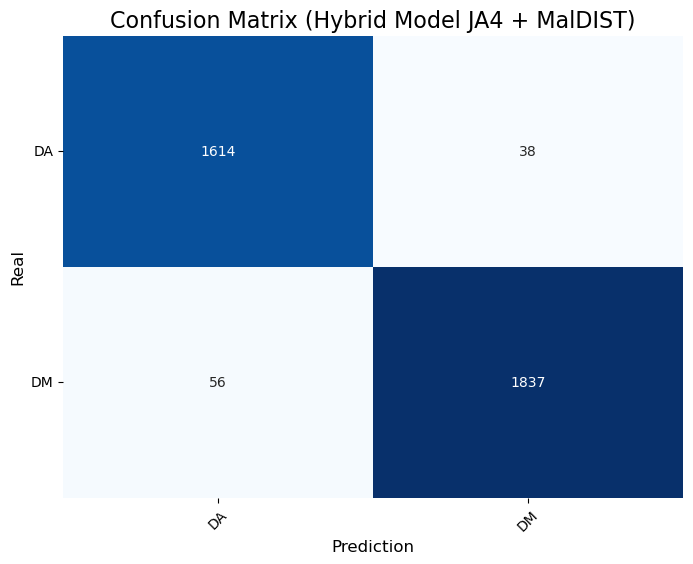

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obtener etiquetas únicas (classes)
classes = label_encoder.classes_  # Si usaste LabelEncoder en 'y'

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=classes, 
    yticklabels=classes,
    cbar=False
)
plt.title('Confusion Matrix (Hybrid Model JA4 + MalDIST)', fontsize=16)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.xticks(rotation=45)  # Rotar etiquetas si son largas
plt.yticks(rotation=0)

plt.savefig('ConfMat_hybrid_model.png', bbox_inches='tight', dpi=300)
plt.show()